In [1]:
# !pip install sentence-transformers

In [2]:
import pandas as pd
import os

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# Load and Join Data

In [3]:
csv_dir = r'C:\Users\Yixuan Liu\Downloads\game analytics\playstation'

csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

dataframes = {}

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    df_name = os.path.splitext(file)[0]  # Use filename (without extension) as key
    dataframes[df_name] = pd.read_csv(file_path)

In [4]:
dataframes.keys()

dict_keys(['achievements', 'games', 'history', 'players', 'player_achievement_cluster_details', 'player_achievement_cluster_total', 'prices', 'purchased_games'])

In [5]:
players = dataframes['players']
achievements = dataframes['achievements']
history = dataframes['history']
games = dataframes['games']

In [6]:
activity = history.join(players, how = 'inner', on = 'playerid', rsuffix = '_hisotry')

In [7]:
activity.drop('playerid_hisotry', axis = 1, inplace = True)

In [8]:
activity

,playerid,achievementid,date_acquired,nickname,country
24489,317180,703215_5666395,2024-11-30 05:26:42,SoyPabloALV,United States
24490,317180,703215_5666394,2024-11-30 04:21:14,SoyPabloALV,United States
24491,317180,703215_5666429,2024-11-30 03:41:35,SoyPabloALV,United States
24492,317180,703215_5666407,2024-11-04 08:07:11,SoyPabloALV,United States
24493,317180,703215_5666393,2024-11-04 07:14:00,SoyPabloALV,United States
...,...,...,...,...,...
19510078,301920,73_769,2010-03-21 02:34:00,Dev1ldreamss,France
19510079,301920,73_2253,2010-03-21 02:17:12,Dev1ldreamss,France
19510080,301920,73_767,2010-03-21 01:48:49,Dev1ldreamss,France
19510081,301920,73_768,2010-03-20 21:41:10,Dev1ldreamss,France


In [9]:
activity['date_acquired'] = pd.to_datetime(activity['date_acquired'])

first_months = activity.groupby('playerid')['date_acquired'].min().dt.to_period('M')

activity['first_activity_month'] = activity['playerid'].map(first_months)

In [10]:
activity['first_activity_month'] = activity['first_activity_month'].astype('period[M]')

activity['current_month'] = activity['date_acquired'].dt.to_period('M')

activity['month_since_first'] = (activity['current_month'] - activity['first_activity_month']).apply(lambda x: x.n)

In [11]:
achievements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846563 entries, 0 to 846562
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   achievementid  846563 non-null  object
 1   gameid         846563 non-null  int64 
 2   title          846559 non-null  object
 3   description    846547 non-null  object
 4   rarity         846563 non-null  object
dtypes: int64(1), object(4)
memory usage: 32.3+ MB


In [12]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7515910 entries, 24489 to 19510082
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   playerid              int64         
 1   achievementid         object        
 2   date_acquired         datetime64[ns]
 3   nickname              object        
 4   country               object        
 5   first_activity_month  period[M]     
 6   current_month         period[M]     
 7   month_since_first     int64         
dtypes: datetime64[ns](1), int64(2), object(3), period[M](2)
memory usage: 516.1+ MB


In [13]:
activity = activity.merge(achievements, on='achievementid', how='inner', suffixes=('', '_a'))

In [14]:
activity.isna().sum()

playerid                0
achievementid           0
date_acquired           0
nickname                0
country                 0
first_activity_month    0
current_month           0
month_since_first       0
gameid                  0
title                   0
description             0
rarity                  0
dtype: int64

In [15]:
activity = activity.merge(games, on='gameid', how='inner', suffixes=('', '_g'))

In [16]:
activity.head(10)

,playerid,achievementid,date_acquired,nickname,country,first_activity_month,current_month,month_since_first,gameid,title,description,rarity,title_g,platform,developers,publishers,genres,supported_languages,release_date
0,317180,703215_5666395,2024-11-30 05:26:42,SoyPabloALV,United States,2009-04,2024-11,187,703215,Target Acquired,Ascertain the location of Morias Leuze,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
1,317180,703215_5666394,2024-11-30 04:21:14,SoyPabloALV,United States,2009-04,2024-11,187,703215,Chaos All Along,Discover the Chaos presence on Kadaku,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
2,317180,703215_5666429,2024-11-30 03:41:35,SoyPabloALV,United States,2009-04,2024-11,187,703215,Field of Battle,Kill 100 enemies using environmental hazards,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
3,317180,703215_5666407,2024-11-04 08:07:11,SoyPabloALV,United States,2009-04,2024-11,187,703215,Crude but Effective,Deploy a bomb in the promethium well to destro...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
4,317180,703215_5666393,2024-11-04 07:14:00,SoyPabloALV,United States,2009-04,2024-11,187,703215,Unleash the Cannon,Destroy the hive ship with the power of anti-a...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
5,317180,703215_5666425,2024-11-04 06:25:33,SoyPabloALV,United States,2009-04,2024-11,187,703215,Unhand My Brother!,Force a Ravener to release a grabbed Squad Member,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
6,317180,703215_5666392,2024-11-04 04:54:02,SoyPabloALV,United States,2009-04,2024-11,187,703215,The Die Is Cast,Rise as a Primaris,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09
7,317180,650140_5310552,2024-11-19 07:08:31,SoyPabloALV,United States,2009-04,2024-11,187,650140,Ship it!,Upgrade all ship modules at least 1 level.,Bronze,Helldivers 2,PS5,['Arrowhead Game Studios'],['Sony Interactive Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-02-08
8,317180,650140_5310538,2024-07-12 07:49:22,SoyPabloALV,United States,2009-04,2024-07,183,650140,Hell Dive,Complete an Extreme difficulty mission or high...,Gold,Helldivers 2,PS5,['Arrowhead Game Studios'],['Sony Interactive Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-02-08
9,317180,650140_5310540,2024-06-26 08:30:03,SoyPabloALV,United States,2009-04,2024-06,182,650140,Gone in 360 seconds!,Complete a full Extreme difficulty Blitz missi...,Gold,Helldivers 2,PS5,['Arrowhead Game Studios'],['Sony Interactive Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-02-08


In [52]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5985641 entries, 0 to 5985640
Data columns (total 21 columns):
 #   Column                Dtype         
---  ------                -----         
 0   playerid              int64         
 1   achievementid         object        
 2   date_acquired         datetime64[ns]
 3   nickname              object        
 4   country               object        
 5   first_activity_month  period[M]     
 6   current_month         period[M]     
 7   month_since_first     int64         
 8   gameid                int64         
 9   title                 object        
 10  description           object        
 11  rarity                object        
 12  title_g               object        
 13  platform              object        
 14  developers            object        
 15  publishers            object        
 16  genres                object        
 17  supported_languages   object        
 18  release_date          object        
 19  

# Prepare the Genres

In [17]:
genres = activity.genres.unique()

In [53]:
len(genres)

530

In [19]:
import ast
import pandas as pd
from itertools import chain

# Step 1: Define the parsing/cleaning function
def parse_genre_list(item):
    """
    Converts a stringified list into a list of clean, lowercase genre tags.
    Handles parsing errors and non-list strings gracefully.
    """
    if isinstance(item, str):
        try:
            parsed = ast.literal_eval(item)
            if isinstance(parsed, list):
                return [x.strip().lower() for x in parsed if isinstance(x, str)]
            else:
                return [str(parsed).strip().lower()]
        except Exception:
            fallback = item.replace('[', '').replace(']', '').replace('"', '').replace("'", "").split(',')
            return [x.strip().lower() for x in fallback if x.strip()]
    else:
        return []

# Step 2: Apply to the column
activity['parsed_genres'] = activity['genres'].apply(parse_genre_list)

# Step 3: Flatten all genre lists into one list
all_genres = list(chain.from_iterable(activity['parsed_genres'].tolist()))

# Step 4: Deduplicate and sort
unique_tags = sorted(set(all_genres))

# Step 5: Print summary
print(f"Extracted {len(all_genres)} genre tags")
print(f"Unique genres ({len(unique_tags)}):")
print(unique_tags)

Extracted 8335931 genre tags
Unique genres (114):
['action', 'action horror', 'action-adventure', 'action-rpg', 'adventure', 'aerial', 'american football', 'arcade', 'arcade racing', 'australian football', 'automobile', 'baseball', 'basketball', 'battle royale', "beat 'em up", 'board games', 'bowling', 'boxing', 'bullfighting', 'card & board', 'casino', 'casual', 'classics', 'collectable card game', 'collection', 'cricket', 'cue sports', 'cycling', 'dance', 'darts', 'dodgeball', 'dungeon crawler', 'education', 'educational', 'educational & trivia', 'equestrian sports', 'family', 'fighting', 'first person shooter', 'fishing', 'flying', 'football', 'fps', 'free to play', 'game preview', 'golf', 'gore', 'hack & slash', 'handball', 'health & fitness', 'hockey', 'horror', 'hunting', 'indie', 'kinect', 'management', 'massively multiplayer', 'mech', 'metroidvania', 'mixed martial arts', 'mmo', 'moba', 'motocross', 'multi-player online battle arena', 'music & rhythm', 'music+', 'music/rhythm',

In [20]:
activity['parsed_genres'] = activity['parsed_genres'].apply(
    lambda genres: ['quiz' if g == '❓ quiz ❓' else g for g in genres]
)

In [21]:
unique_tags.remove('❓ quiz ❓')
unique_tags.append('quiz')

In [22]:
genre_groups = {
    "Action & Combat": [
        "action", "action horror", "action-adventure", "action-rpg", "hack & slash",
        "beat 'em up", "fighting", "stealth", "survival", "survival horror",
        "gore", "violent", "run & gun", "shoot 'em up", "shooter", "fps",
        "first person shooter", "third person shooter", "dungeon crawler", "roguelite",
        "mixed martial arts", "boxing", "wrestling", "horror", "sexual content"
    ],
    "Sports & Racing": [
        "sports", "football", "american football", "australian football", "rugby", "basketball",
        "baseball", "volleyball", "handball", "cricket", "cue sports", "tennis",
        "table tennis", "hockey", "golf", "bowling", "dodgeball", "bullfighting",
        "cycling", "skiing", "snowboarding", "surfing", "skating", "skateboarding",
        "motocross", "racing", "simulation racing", "arcade racing", "automobile"
    ],
    "Online & Multiplayer": [
        "massively multiplayer", "battle royale", "mmo", "moba", "multi-player online battle arena",
        "multi-player", "vehicular combat", "naval", "mech"
    ],
    "Arcade & Classics": [
        "arcade", "platformer", "pinball", "point & click", "on rails", "classics",
        "collection", "game preview", "casual", "indie", "free to play"
    ],
    "Strategy & Simulation": [
        "strategy", "simulation", "simulation racing", "management", "sandbox",
        "open world", "tower defence", "turn based", "role playing", "role-playing games (rpg)",
        "rpg", "metroidvania"
    ],
    "Puzzle & Educational": [
        "puzzle", "education", "educational", "educational & trivia", "quiz", "tutorial"
    ],
    "Card, Board & Casino": [
        "card & board", "board games", "collectable card game", "casino"
    ],
    "Music, Party & Social": [
        "music & rhythm", "music+", "music/rhythm", "dance", "party", "party!",
        "social", "kinect"
    ],
    "Thematic & Narrative": [
        "visual novel", "family", "health & fitness", "adventure", "flying", "aerial",
        "skydiving", "fishing", "hunting"
    ]
}

# Create a reverse mapping: genre -> group
tag_to_group = {}
for group, tags in genre_groups.items():
    for tag in tags:
        tag_to_group[tag.lower()] = group

# Function to map parsed_genres to genre groups
def map_genres_to_group(genre_list):
    if not isinstance(genre_list, list):
        return None
    for tag in genre_list:
        group = tag_to_group.get(tag.lower())
        if group:
            return group
    return None  # if no match found

# Apply the function to your DataFrame
activity['genre_group'] = activity['parsed_genres'].apply(map_genres_to_group)

print(activity[['parsed_genres', 'genre_group']].head())

            parsed_genres      genre_group
0  [third person shooter]  Action & Combat
1  [third person shooter]  Action & Combat
2  [third person shooter]  Action & Combat
3  [third person shooter]  Action & Combat
4  [third person shooter]  Action & Combat


In [58]:
genre_groups.keys()

dict_keys(['Action & Combat', 'Sports & Racing', 'Online & Multiplayer', 'Arcade & Classics', 'Strategy & Simulation', 'Puzzle & Educational', 'Card, Board & Casino', 'Music, Party & Social', 'Thematic & Narrative'])

In [23]:
grouped = activity.groupby(['playerid', 'genre_group', 'rarity'])['achievementid'].count()

In [24]:
activity.head()

,playerid,achievementid,date_acquired,nickname,country,first_activity_month,current_month,month_since_first,gameid,title,...,rarity,title_g,platform,developers,publishers,genres,supported_languages,release_date,parsed_genres,genre_group
0,317180,703215_5666395,2024-11-30 05:26:42,SoyPabloALV,United States,2009-04,2024-11,187,703215,Target Acquired,...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09,[third person shooter],Action & Combat
1,317180,703215_5666394,2024-11-30 04:21:14,SoyPabloALV,United States,2009-04,2024-11,187,703215,Chaos All Along,...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09,[third person shooter],Action & Combat
2,317180,703215_5666429,2024-11-30 03:41:35,SoyPabloALV,United States,2009-04,2024-11,187,703215,Field of Battle,...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09,[third person shooter],Action & Combat
3,317180,703215_5666407,2024-11-04 08:07:11,SoyPabloALV,United States,2009-04,2024-11,187,703215,Crude but Effective,...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09,[third person shooter],Action & Combat
4,317180,703215_5666393,2024-11-04 07:14:00,SoyPabloALV,United States,2009-04,2024-11,187,703215,Unleash the Cannon,...,Bronze,"Warhammer 40,000: Space Marine 2",PS5,['Saber Interactive'],['Focus Entertainment'],['Third Person Shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2024-09-09,[third person shooter],Action & Combat


In [25]:
flattened = grouped.unstack(['genre_group', 'rarity']).fillna(0).astype(int)

flattened.columns = [f"{genre} {rarity}" for genre, rarity in flattened.columns]

flattened = flattened.reset_index()

# View result
flattened.head()

,playerid,Action & Combat Bronze,Action & Combat Gold,Action & Combat Silver,Arcade & Classics Bronze,Arcade & Classics Gold,Arcade & Classics Silver,"Music, Party & Social Bronze","Music, Party & Social Gold","Music, Party & Social Silver",...,Strategy & Simulation Platinum,Thematic & Narrative Platinum,"Card, Board & Casino Bronze","Card, Board & Casino Silver",Puzzle & Educational Gold,"Card, Board & Casino Gold",Online & Multiplayer Gold,Puzzle & Educational Platinum,Online & Multiplayer Platinum,"Card, Board & Casino Platinum"
0,77,925,27,166,87,8,29,3,2,3,...,0,0,0,0,0,0,0,0,0,0
1,145,1415,130,326,144,16,52,47,2,7,...,15,9,0,0,0,0,0,0,0,0
2,276,218,6,25,27,0,3,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,453,378,27,83,49,0,14,30,0,1,...,0,0,4,0,0,0,0,0,0,0
4,904,568,54,126,94,26,56,84,1,7,...,5,4,23,2,2,0,0,0,0,0


In [26]:
flattened.describe()

,playerid,Action & Combat Bronze,Action & Combat Gold,Action & Combat Silver,Arcade & Classics Bronze,Arcade & Classics Gold,Arcade & Classics Silver,"Music, Party & Social Bronze","Music, Party & Social Gold","Music, Party & Social Silver",...,Strategy & Simulation Platinum,Thematic & Narrative Platinum,"Card, Board & Casino Bronze","Card, Board & Casino Silver",Puzzle & Educational Gold,"Card, Board & Casino Gold",Online & Multiplayer Gold,Puzzle & Educational Platinum,Online & Multiplayer Platinum,"Card, Board & Casino Platinum"
count,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,...,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000
mean,224621.618764,1359.696203,146.838421,357.243485,206.731199,83.424423,90.297096,34.294118,3.469099,31.782576,...,10.633656,10.163068,7.348474,1.266567,22.438570,1.772152,1.224125,2.810871,0.152643,0.171258
std,118706.206174,1374.347133,400.505936,466.317371,300.812187,339.129707,193.148323,65.582310,10.491941,82.068392,...,17.677981,28.166147,15.294060,4.066380,145.716112,16.649545,3.072587,18.804191,0.519162,1.525885
min,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92236.000000,386.500000,17.500000,75.000000,39.000000,2.000000,10.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,287488.000000,1005.000000,60.000000,224.000000,119.000000,13.000000,37.000000,11.000000,0.000000,2.000000,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,330084.500000,1878.500000,140.000000,467.000000,258.500000,44.000000,95.500000,41.000000,3.000000,17.000000,...,13.000000,10.000000,9.000000,1.000000,4.500000,0.000000,1.000000,0.000000,0.000000,0.000000
max,356550.000000,13757.000000,5982.000000,5069.000000,3364.000000,6271.000000,2466.000000,657.000000,236.000000,764.000000,...,159.000000,722.000000,131.000000,56.000000,3675.000000,440.000000,25.000000,458.000000,6.000000,40.000000


In [27]:
flattened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   playerid                        1343 non-null   int64
 1   Action & Combat Bronze          1343 non-null   int32
 2   Action & Combat Gold            1343 non-null   int32
 3   Action & Combat Silver          1343 non-null   int32
 4   Arcade & Classics Bronze        1343 non-null   int32
 5   Arcade & Classics Gold          1343 non-null   int32
 6   Arcade & Classics Silver        1343 non-null   int32
 7   Music, Party & Social Bronze    1343 non-null   int32
 8   Music, Party & Social Gold      1343 non-null   int32
 9   Music, Party & Social Silver    1343 non-null   int32
 10  Online & Multiplayer Bronze     1343 non-null   int32
 11  Online & Multiplayer Silver     1343 non-null   int32
 12  Puzzle & Educational Bronze     1343 non-null   int32
 13  Puz

In [28]:
flattened['playerid'] = flattened['playerid'].astype(str)

In [29]:
genre_columns = flattened.columns.to_list()
genre_columns.remove('playerid')

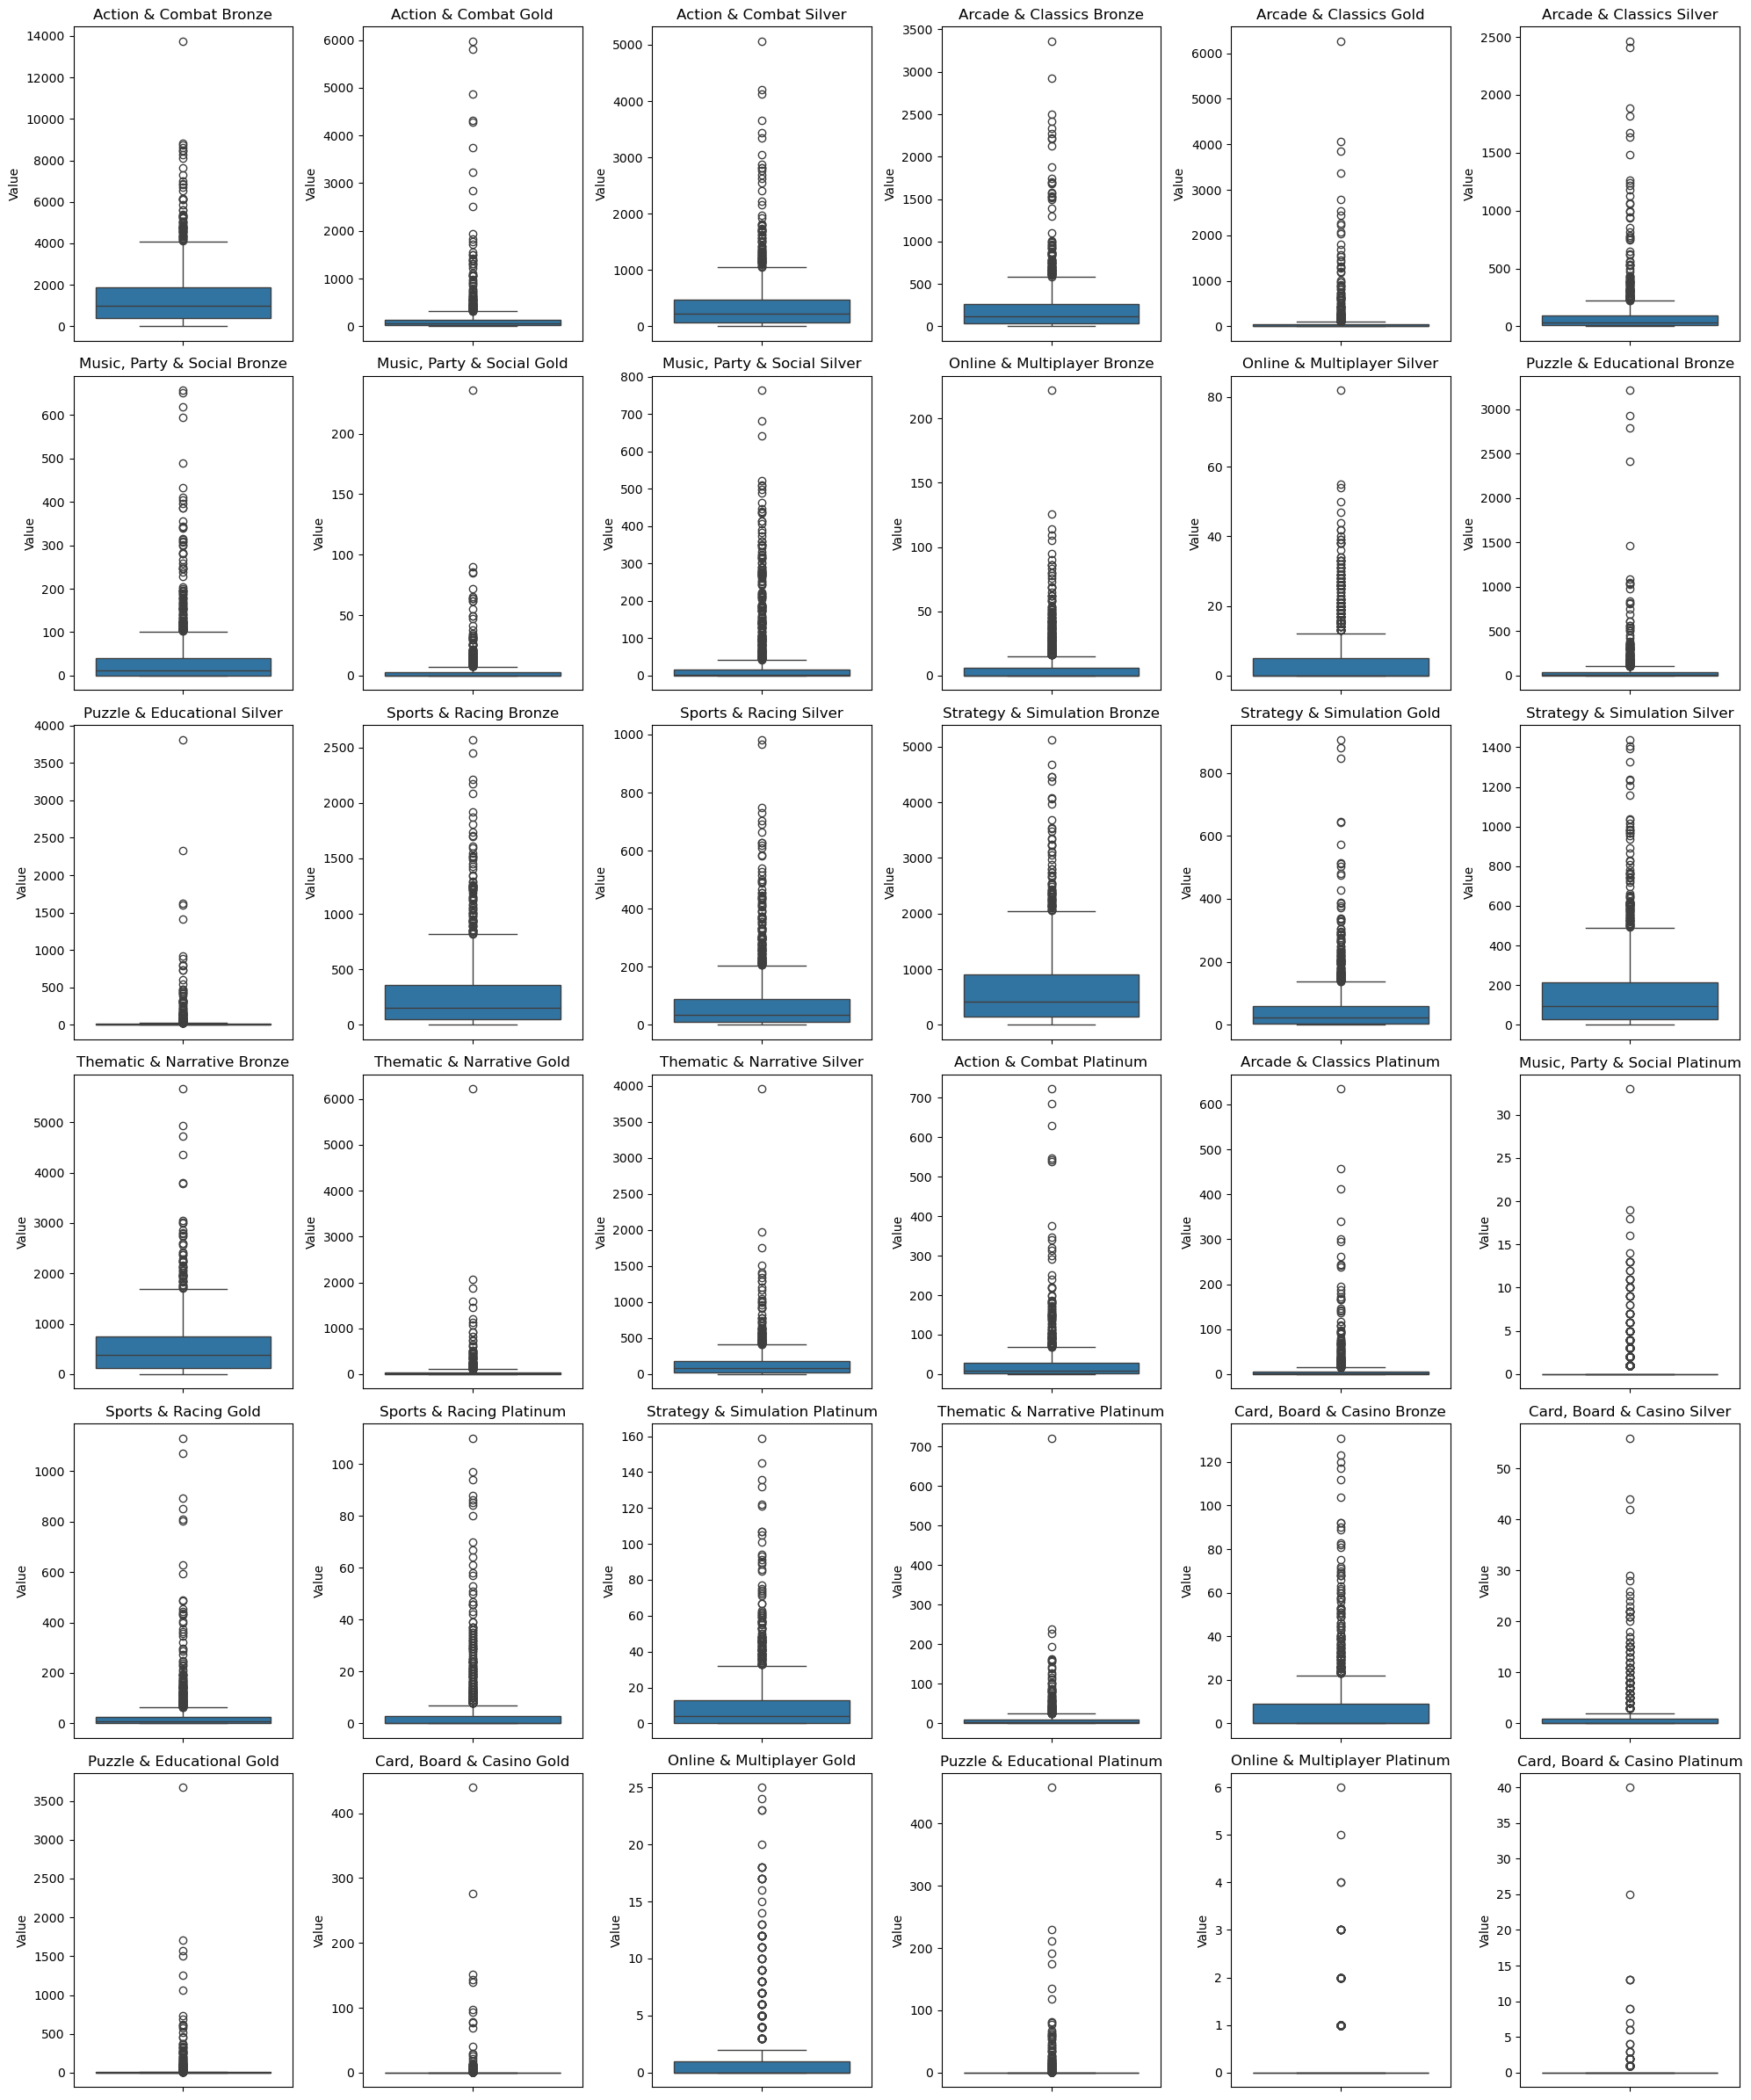

In [59]:
# Plot all Genre + Rarity Count
import seaborn as sns
import matplotlib.pyplot as plt

cols = genre_columns
n_cols = 6
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=flattened[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Hide x-labels
    axes[i].set_ylabel('Value')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.savefig('genre_rarity_distribution.png')
plt.tight_layout()
plt.show()

In [31]:
flattened = flattened[sorted(flattened.columns)]

In [32]:
flattened_w_total = flattened.copy()

In [33]:
for genre in genre_groups:
    genre_cols = [col for col in flattened_w_total.columns if col.startswith(genre + ' ')]
    flattened_w_total[genre + ' Total'] = flattened_w_total[genre_cols].sum(axis=1)

In [34]:
flattened_w_total = flattened_w_total[sorted(flattened_w_total.columns)]
flattened_w_total

,Action & Combat Bronze,Action & Combat Gold,Action & Combat Platinum,Action & Combat Silver,Action & Combat Total,Arcade & Classics Bronze,Arcade & Classics Gold,Arcade & Classics Platinum,Arcade & Classics Silver,Arcade & Classics Total,...,Strategy & Simulation Gold,Strategy & Simulation Platinum,Strategy & Simulation Silver,Strategy & Simulation Total,Thematic & Narrative Bronze,Thematic & Narrative Gold,Thematic & Narrative Platinum,Thematic & Narrative Silver,Thematic & Narrative Total,playerid
0,925,27,0,166,1118,87,8,0,29,124,...,3,0,43,308,212,1,0,20,233,77
1,1415,130,34,326,1905,144,16,4,52,216,...,49,15,155,828,416,26,9,97,548,145
2,218,6,0,25,249,27,0,0,3,30,...,5,1,19,169,50,1,0,13,64,276
3,378,27,3,83,491,49,0,0,14,63,...,2,0,11,105,91,3,0,19,113,453
4,568,54,8,126,756,94,26,4,56,180,...,24,5,102,640,281,13,4,80,378,904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,231,15,5,51,302,110,32,7,87,236,...,13,5,87,293,378,15,7,149,549,355648
1339,1565,73,8,332,1978,76,16,1,25,118,...,143,29,529,2864,407,19,3,60,489,355763
1340,48,3,0,7,58,1,0,0,0,1,...,2,0,8,52,83,4,1,8,96,356282
1341,1740,162,21,500,2423,430,137,11,147,725,...,62,11,180,1090,766,61,8,154,989,356372


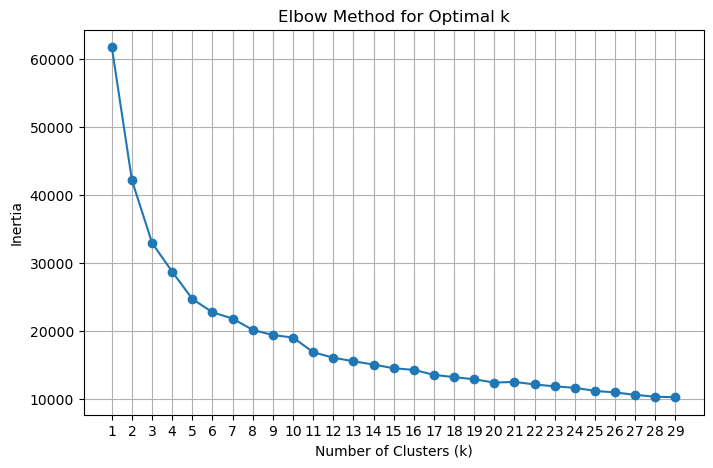

In [65]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Prepare data (drop playerid and scale features)
X = flattened_w_total.drop(columns=['playerid'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Compute inertia for a range of k values
inertias = []
k_range = range(1, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 3. Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)

plt.savefig('elbow.png')
plt.show()


In [36]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

In [37]:
flattened_w_total['cluster'] = cluster_labels

In [38]:
flattened_w_total

,Action & Combat Bronze,Action & Combat Gold,Action & Combat Platinum,Action & Combat Silver,Action & Combat Total,Arcade & Classics Bronze,Arcade & Classics Gold,Arcade & Classics Platinum,Arcade & Classics Silver,Arcade & Classics Total,...,Strategy & Simulation Platinum,Strategy & Simulation Silver,Strategy & Simulation Total,Thematic & Narrative Bronze,Thematic & Narrative Gold,Thematic & Narrative Platinum,Thematic & Narrative Silver,Thematic & Narrative Total,playerid,cluster
0,925,27,0,166,1118,87,8,0,29,124,...,0,43,308,212,1,0,20,233,77,0
1,1415,130,34,326,1905,144,16,4,52,216,...,15,155,828,416,26,9,97,548,145,0
2,218,6,0,25,249,27,0,0,3,30,...,1,19,169,50,1,0,13,64,276,0
3,378,27,3,83,491,49,0,0,14,63,...,0,11,105,91,3,0,19,113,453,0
4,568,54,8,126,756,94,26,4,56,180,...,5,102,640,281,13,4,80,378,904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,231,15,5,51,302,110,32,7,87,236,...,5,87,293,378,15,7,149,549,355648,0
1339,1565,73,8,332,1978,76,16,1,25,118,...,29,529,2864,407,19,3,60,489,355763,4
1340,48,3,0,7,58,1,0,0,0,1,...,0,8,52,83,4,1,8,96,356282,0
1341,1740,162,21,500,2423,430,137,11,147,725,...,11,180,1090,766,61,8,154,989,356372,4


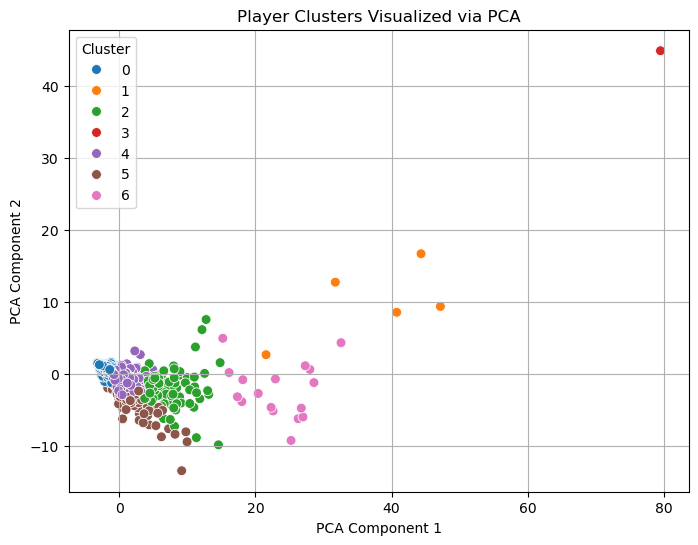

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reduce dimensions to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2. Create a DataFrame for visualization
viz_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'cluster': flattened_w_total['cluster']
})

# 3. Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=50)
plt.title('Player Clusters Visualized via PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)


plt.savefig(('clustering_plot.png'))
plt.show()


In [40]:
total_columns = [col for col in flattened_w_total.columns if col.endswith('Total')] + ['cluster', 'playerid']
trophies_total = flattened_w_total[total_columns]

cols_to_keep = [col for col in flattened_w_total.columns if not col.endswith('Total')]
trophies_details = flattened_w_total[cols_to_keep]

In [41]:
trophies_total[trophies_total['cluster'] == 1]

,Action & Combat Total,Arcade & Classics Total,"Card, Board & Casino Total","Music, Party & Social Total",Online & Multiplayer Total,Puzzle & Educational Total,Sports & Racing Total,Strategy & Simulation Total,Thematic & Narrative Total,cluster,playerid
801,9598,1815,0,148,74,6166,2793,2532,1410,1,305840
1062,25354,5781,127,414,62,6625,4764,2593,4615,1,333392
1087,15035,8657,359,900,18,2864,1580,5002,6436,1,336194
1095,16576,10352,190,577,90,4763,2300,6850,6060,1,336946
1103,17770,6005,25,606,0,6143,1606,1634,3596,1,337417


In [42]:
trophies_details

,Action & Combat Bronze,Action & Combat Gold,Action & Combat Platinum,Action & Combat Silver,Arcade & Classics Bronze,Arcade & Classics Gold,Arcade & Classics Platinum,Arcade & Classics Silver,"Card, Board & Casino Bronze","Card, Board & Casino Gold",...,Strategy & Simulation Bronze,Strategy & Simulation Gold,Strategy & Simulation Platinum,Strategy & Simulation Silver,Thematic & Narrative Bronze,Thematic & Narrative Gold,Thematic & Narrative Platinum,Thematic & Narrative Silver,playerid,cluster
0,925,27,0,166,87,8,0,29,0,0,...,262,3,0,43,212,1,0,20,77,0
1,1415,130,34,326,144,16,4,52,0,0,...,609,49,15,155,416,26,9,97,145,0
2,218,6,0,25,27,0,0,3,0,0,...,144,5,1,19,50,1,0,13,276,0
3,378,27,3,83,49,0,0,14,4,0,...,92,2,0,11,91,3,0,19,453,0
4,568,54,8,126,94,26,4,56,23,0,...,509,24,5,102,281,13,4,80,904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,231,15,5,51,110,32,7,87,0,0,...,188,13,5,87,378,15,7,149,355648,0
1339,1565,73,8,332,76,16,1,25,12,0,...,2163,143,29,529,407,19,3,60,355763,4
1340,48,3,0,7,1,0,0,0,0,0,...,42,2,0,8,83,4,1,8,356282,0
1341,1740,162,21,500,430,137,11,147,5,0,...,837,62,11,180,766,61,8,154,356372,4


In [43]:
trophies_total.drop('playerid', axis = 1).groupby('cluster').mean()

,Action & Combat Total,Arcade & Classics Total,"Card, Board & Casino Total","Music, Party & Social Total",Online & Multiplayer Total,Puzzle & Educational Total,Sports & Racing Total,Strategy & Simulation Total,Thematic & Narrative Total
cluster,,,,,,,,,
0,726.505195,104.232468,2.815584,16.212987,4.228571,12.162338,168.393506,310.085714,265.200000
1,16866.600000,6522.000000,140.200000,529.000000,48.800000,5312.200000,2608.600000,3722.200000,4423.400000
2,5197.606383,1269.553191,31.021277,304.946809,22.319149,361.106383,1086.702128,2527.148936,2141.765957
3,15296.000000,11197.000000,536.000000,1684.000000,56.000000,10364.000000,1431.000000,2746.000000,16568.000000
4,2509.601064,437.859043,15.651596,85.106383,8.678191,76.558511,481.877660,1298.156915,1003.045213
5,3222.975000,448.512500,9.325000,88.675000,80.512500,83.100000,535.112500,1318.362500,1013.025000
6,11032.764706,4691.588235,72.235294,579.117647,59.058824,1517.235294,1920.529412,4354.588235,4957.117647


In [44]:
trophies_total.drop('playerid', axis = 1).groupby('cluster')['Action & Combat Total'].count()

cluster
0    770
1      5
2     94
3      1
4    376
5     80
6     17
Name: Action & Combat Total, dtype: int64

# 🎮 Cluster Analysis of Player Trophies by Genre

From the K-means clustering results, we identified **7 distinct player clusters** based on the total number of trophies earned in each genre. Below is an interpretation of each cluster, ordered by the number of players within each group:

---

## 1. Cluster 0 – Casual Players  
**Size:** 770 players  

- These players show low engagement across all genres.  
- Their trophy activity is concentrated in **Action & Combat**, **Strategy & Simulation**, and **Thematic & Narrative**, though the counts remain significantly lower than other clusters.  
- Likely to be casual users or newer players who haven't explored many games or genres extensively.

---

## 2. Cluster 4 – Moderately Engaged Players  
**Size:** 376 players  

- Similar genre preferences to Cluster 0, but with noticeably higher engagement across most categories.  
- Shows increased interest in **Arcade & Classics**, suggesting deeper genre exploration beyond just mainstream titles.

---

## 3. Cluster 2 – Niche Genre Explorers  
**Size:** 94 players  

- Builds upon the activity patterns seen in Cluster 4, but with even greater engagement across **smaller or niche genres**.  
- Particularly more involved in **Arcade & Classics** and **Puzzle & Educational**, suggesting a willingness to experiment beyond traditional action/strategy genres.

---

## 4. Cluster 5 – Social Gamers  
**Size:** 80 players  

- Comparable overall engagement to Cluster 4, but stands out for significantly higher activity in **Online & Multiplayer** titles.  
- Also shows stronger performance in **Action & Combat**, which aligns with popular multiplayer formats—both competitive and cooperative.  
- Likely represents players who enjoy shared gaming experiences and community-driven play.

---

## 5. Clusters 6, 1, and 3 – Hardcore Gamers  
**Combined Size:** 23 players (17 + 5 + 1)  

- These three clusters feature players with **exceptionally high trophy counts** across nearly all genres.  
- **Cluster 6** represents general hardcore gamers with consistent high engagement in mainstream categories.  
- **Cluster 1** shows extreme specialization in **Action & Combat** and **Sports & Racing**, suggesting a taste for fast-paced, adrenaline-fueled games.  
- **Cluster 3**, though it contains only one player, demonstrates unparalleled activity in **Thematic & Narrative** and **Puzzle & Educational**, possibly indicating a completionist or RPG enthusiast. However, due to its size, this cluster provides limited generalizable insight.  
- Overall, these players are highly engaged, likely completionists, genre experts, or long-term enthusiasts.

---

## 🧠 Summary

The clustering analysis reveals a spectrum of player types—from casual participants to niche explorers and hardcore completionists. This segmentation can inform personalized engagement strategies, game recommendations, and community initiatives tailored to each player type’s behavior and preferences. Notably:

- **Clusters 0–2** represent the bulk of the user base, offering opportunities for onboarding, progression nudges, or retention efforts.  
- **Clusters 4–5** indicate mid-core users ready for tailored challenges or social features.  
- **Clusters 6, 1, and 3** consist of highly valuable users whose play patterns can inspire community content, elite reward systems, or ambassador programs.


In [45]:
cluster_name_map = {
    0: 'Casual Players',
    4: 'Moderately Engaged Players',
    2: 'Niche Genre Explorers',
    5: 'Social Gamers',
    6: 'Hardcore Gamers',
    1: 'Hardcore Gamers',
    3: 'Hardcore Gamers'
}

trophies_total['cluster_name'] = trophies_total['cluster'].map(cluster_name_map)
trophies_details['cluster_name'] = trophies_details['cluster'].map(cluster_name_map)

In [46]:
trophies_total

,Action & Combat Total,Arcade & Classics Total,"Card, Board & Casino Total","Music, Party & Social Total",Online & Multiplayer Total,Puzzle & Educational Total,Sports & Racing Total,Strategy & Simulation Total,Thematic & Narrative Total,cluster,playerid,cluster_name
0,1118,124,0,8,10,7,49,308,233,0,77,Casual Players
1,1905,216,0,57,0,5,128,828,548,0,145,Casual Players
2,249,30,0,0,0,5,181,169,64,0,276,Casual Players
3,491,63,4,31,0,0,92,105,113,0,453,Casual Players
4,756,180,25,92,0,54,233,640,378,0,904,Casual Players
...,...,...,...,...,...,...,...,...,...,...,...,...
1338,302,236,0,0,0,0,835,293,549,0,355648,Casual Players
1339,1978,118,12,15,45,0,274,2864,489,4,355763,Moderately Engaged Players
1340,58,1,0,0,0,0,306,52,96,0,356282,Casual Players
1341,2423,725,7,17,18,113,1070,1090,989,4,356372,Moderately Engaged Players


In [47]:
trophies_total.to_csv('player_achievement_cluster_total.csv', index=False)
trophies_details.to_csv('player_achievement_cluster_details.csv', index=False)

In [48]:
# Define ID columns
id_columns = ['playerid', 'cluster', 'cluster_name']

# Melt the dataframe from wide to long format
df_long = trophies_details.melt(
    id_vars=id_columns,
    var_name='Genre + Rarity',
    value_name='Trophy Count'
)

# Split 'Genre + Rarity' into separate Genre and Rarity columns
df_long[['Genre', 'Rarity']] = df_long['Genre + Rarity'].str.rsplit(' ', n=1, expand=True)

# Drop the original combined column
df_long.drop(columns=['Genre + Rarity'], inplace=True)

In [49]:
df_long

,playerid,cluster,cluster_name,Trophy Count,Genre,Rarity
0,77,0,Casual Players,925,Action & Combat,Bronze
1,145,0,Casual Players,1415,Action & Combat,Bronze
2,276,0,Casual Players,218,Action & Combat,Bronze
3,453,0,Casual Players,378,Action & Combat,Bronze
4,904,0,Casual Players,568,Action & Combat,Bronze
...,...,...,...,...,...,...
48343,355648,0,Casual Players,149,Thematic & Narrative,Silver
48344,355763,4,Moderately Engaged Players,60,Thematic & Narrative,Silver
48345,356282,0,Casual Players,8,Thematic & Narrative,Silver
48346,356372,4,Moderately Engaged Players,154,Thematic & Narrative,Silver


In [50]:
df_long.sort_values(['playerid', 'Genre']).to_csv('player_achievement_cluster_details.csv', index = False)